# Visualizing Stability

## Investigating within and across z algorithm stability with SVCCA

**Gregory Way 2018**

Visualizing the stability of compression algorithms across different bottleneck dimensionalities.
This notebook visualizes the output generated from `3.stability-within-z.ipynb` and `4.stability-across-z.ipynb`.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(RColorBrewer))

In [2]:
# Define the dataset to compile results for
svcca_file <- file.path("results", "svcca_within_mean_correlation_weights.tsv.gz")
svcca_df <- readr::read_tsv(svcca_file,
                            col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double()))
print(dim(svcca_df))
head(svcca_df, 2)

[1] 148150      8


seed_1,seed_2,algorithm_1,algorithm_2,svcca_mean_similarity,dataset,z_dim,shuffled
773880,468749,pca,pca,0.01711836,TARGET,2,shuffled
773880,468749,pca,ica,0.01239303,TARGET,2,shuffled


In [3]:
table(svcca_df$shuffled)


shuffled   signal 
   57750    90400 

In [4]:
 # Make sure factors are in order
svcca_df$z_dim <- factor(
    svcca_df$z_dim,
    levels = sort(as.numeric(paste(unique(svcca_df$z_dim))))
)

algorithms <- c("pca", "ica", "nmf", "dae", "vae")

svcca_df$algorithm_1 <- factor(
    svcca_df$algorithm_1,
    levels = algorithms
)

svcca_df$algorithm_2 <- factor(
    svcca_df$algorithm_2,
    levels = algorithms
)

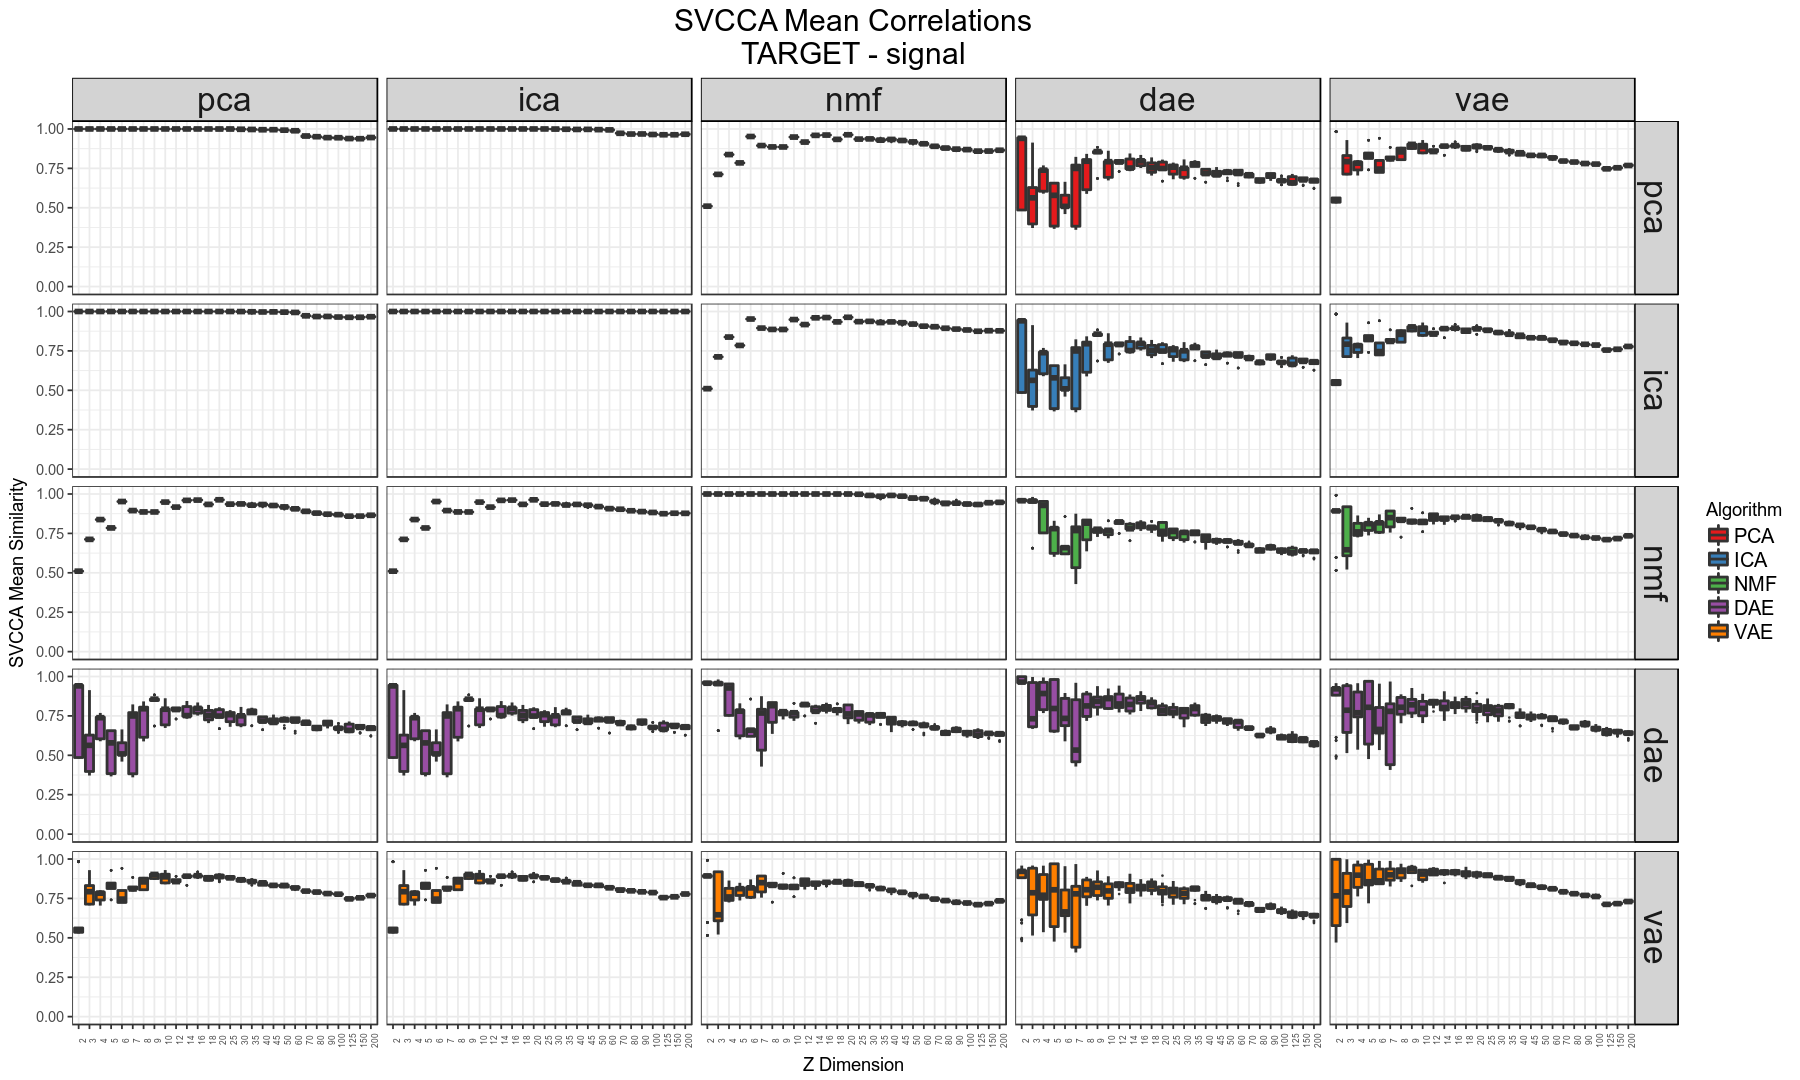

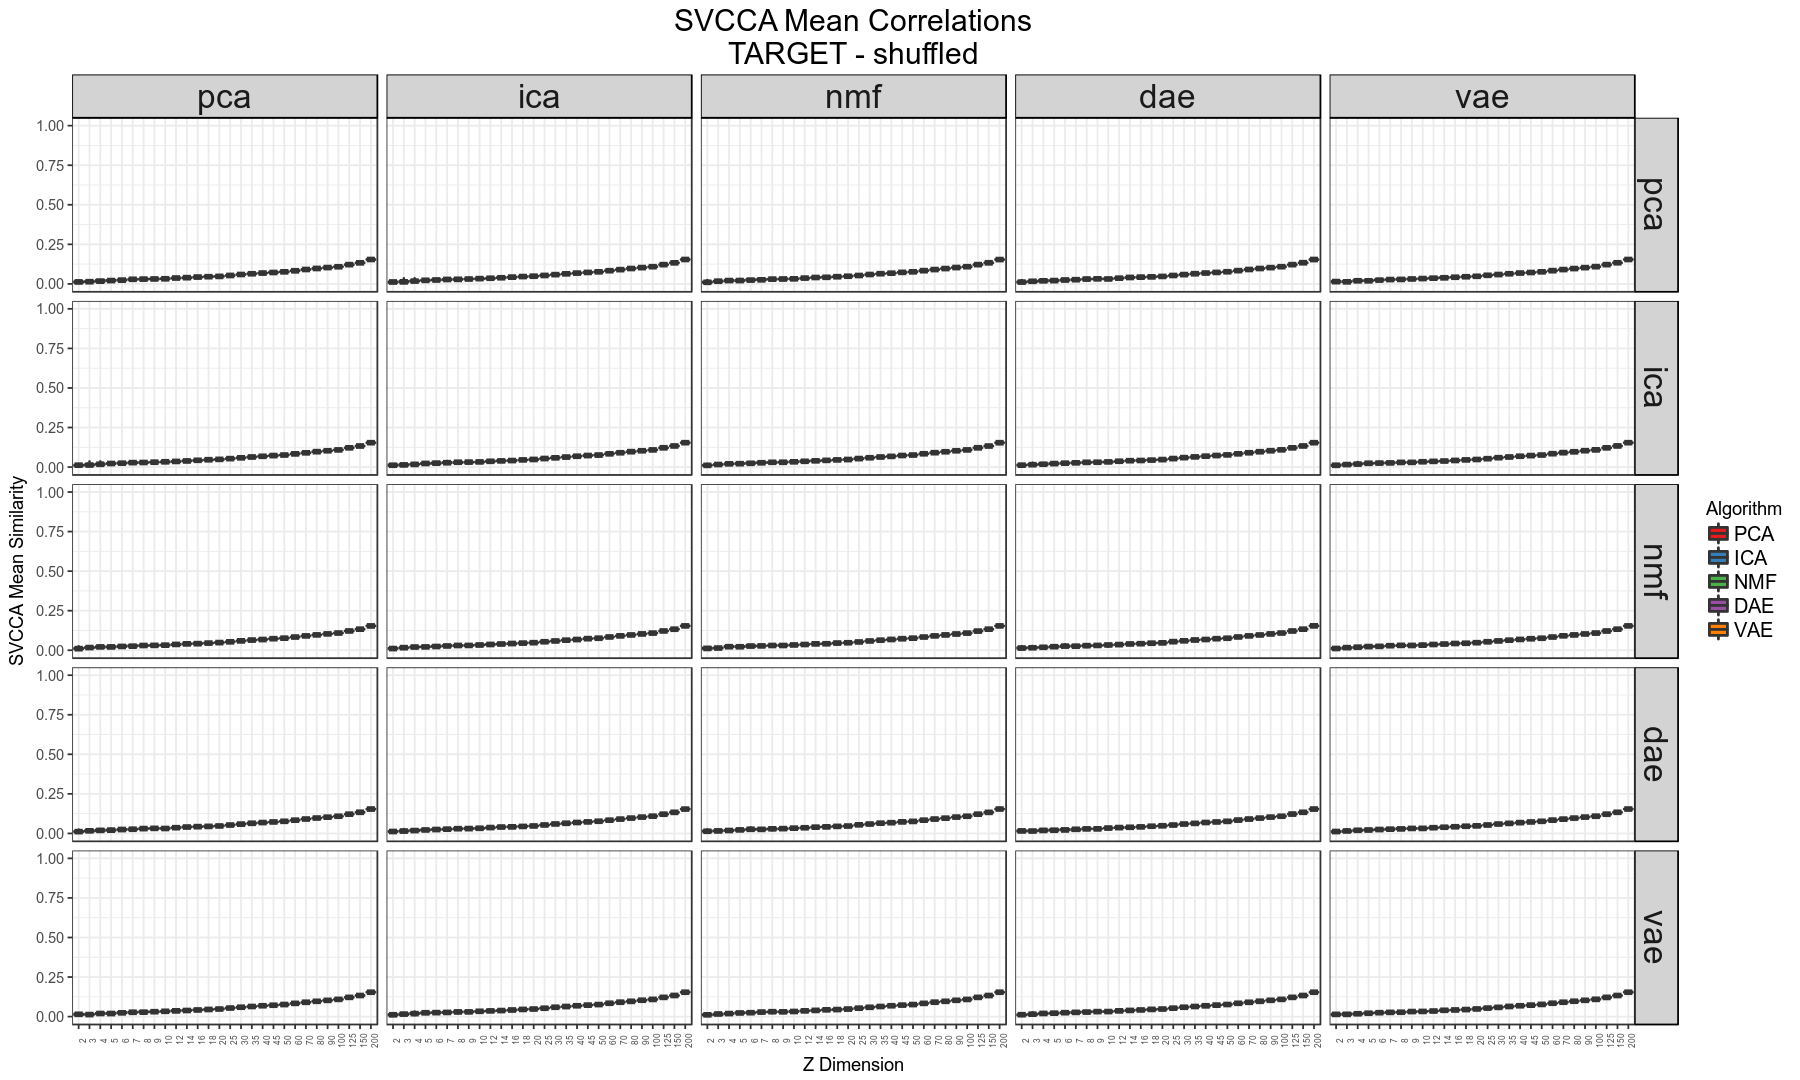

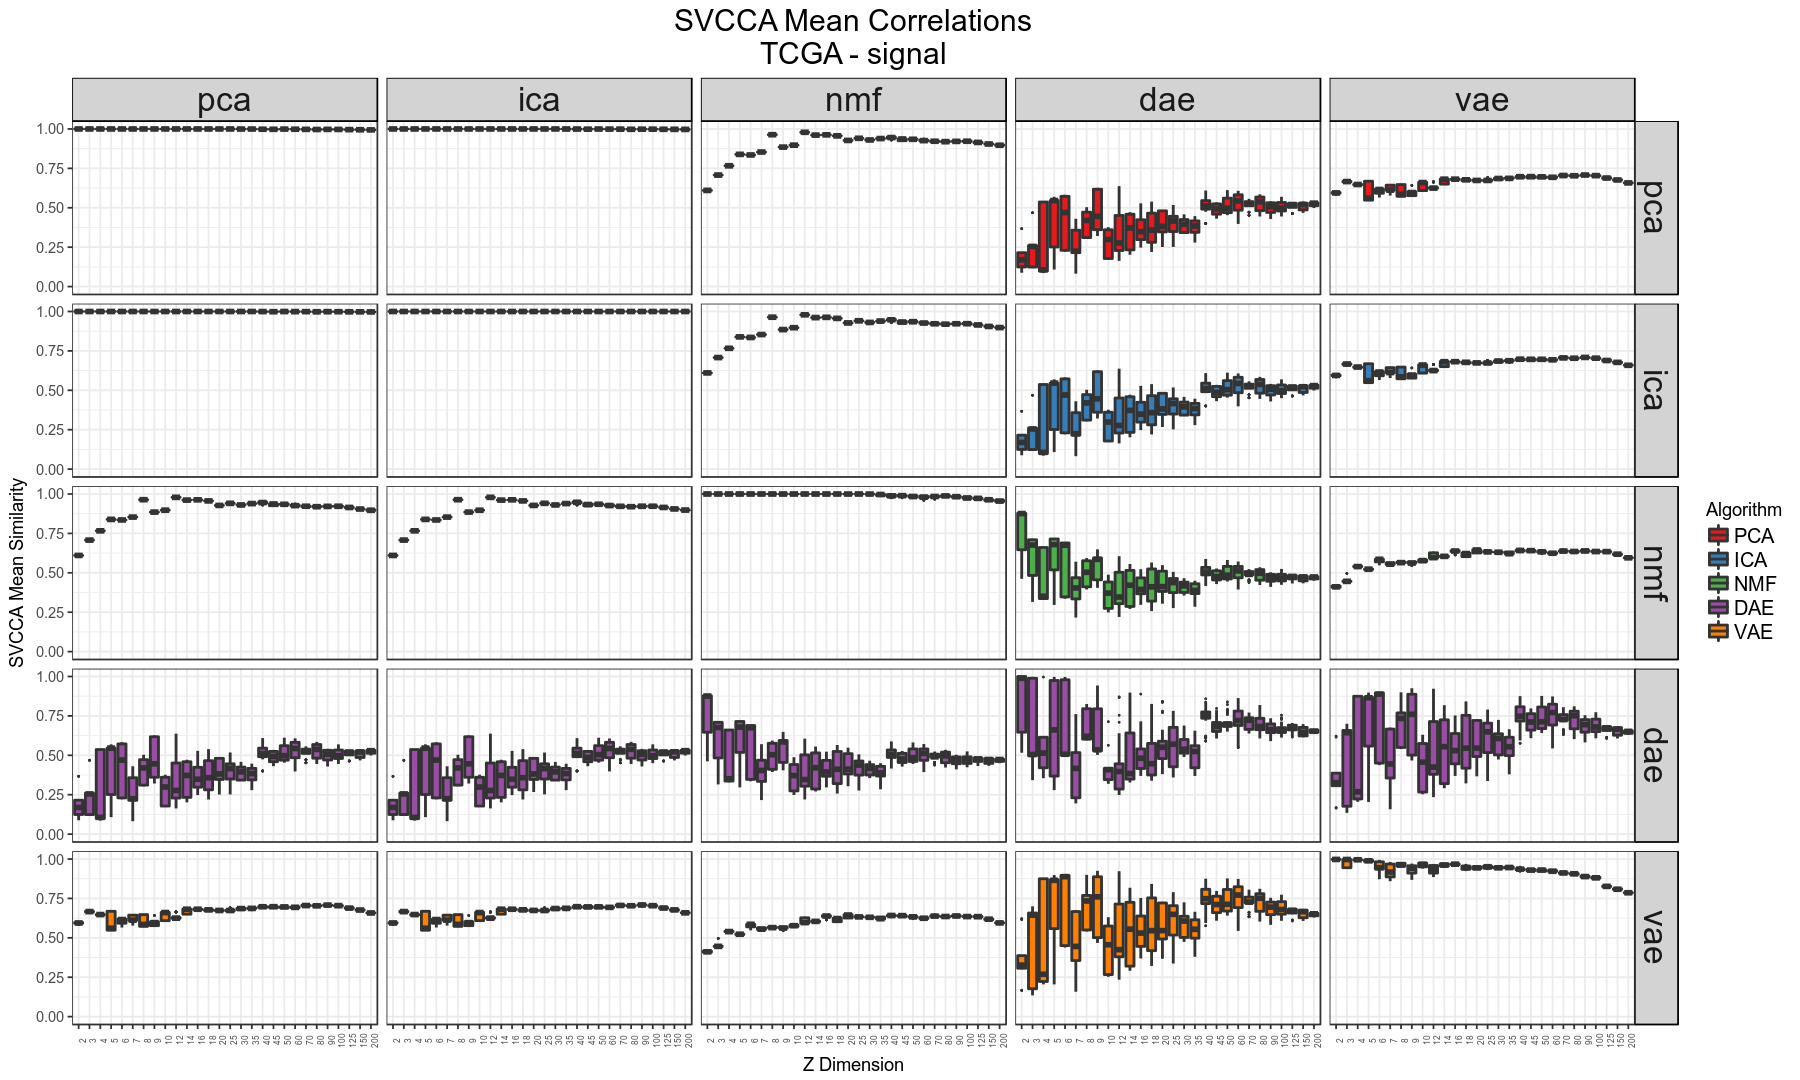

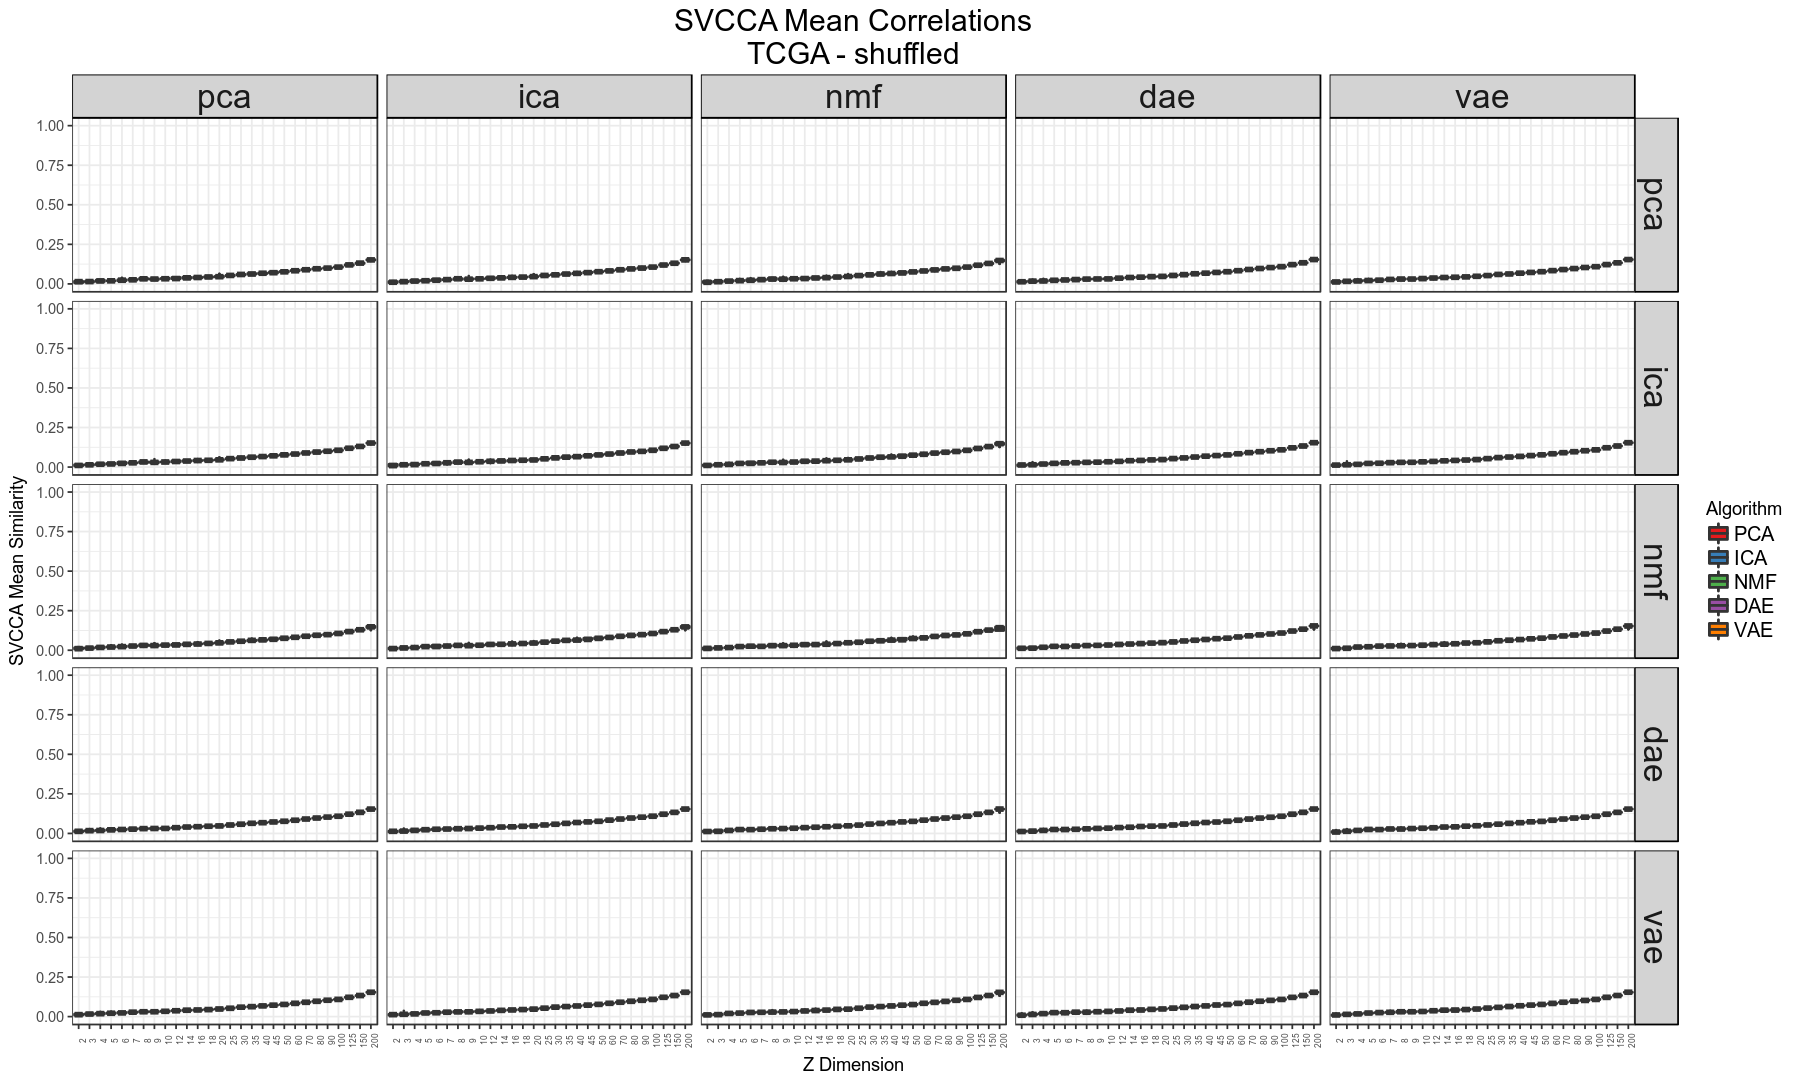

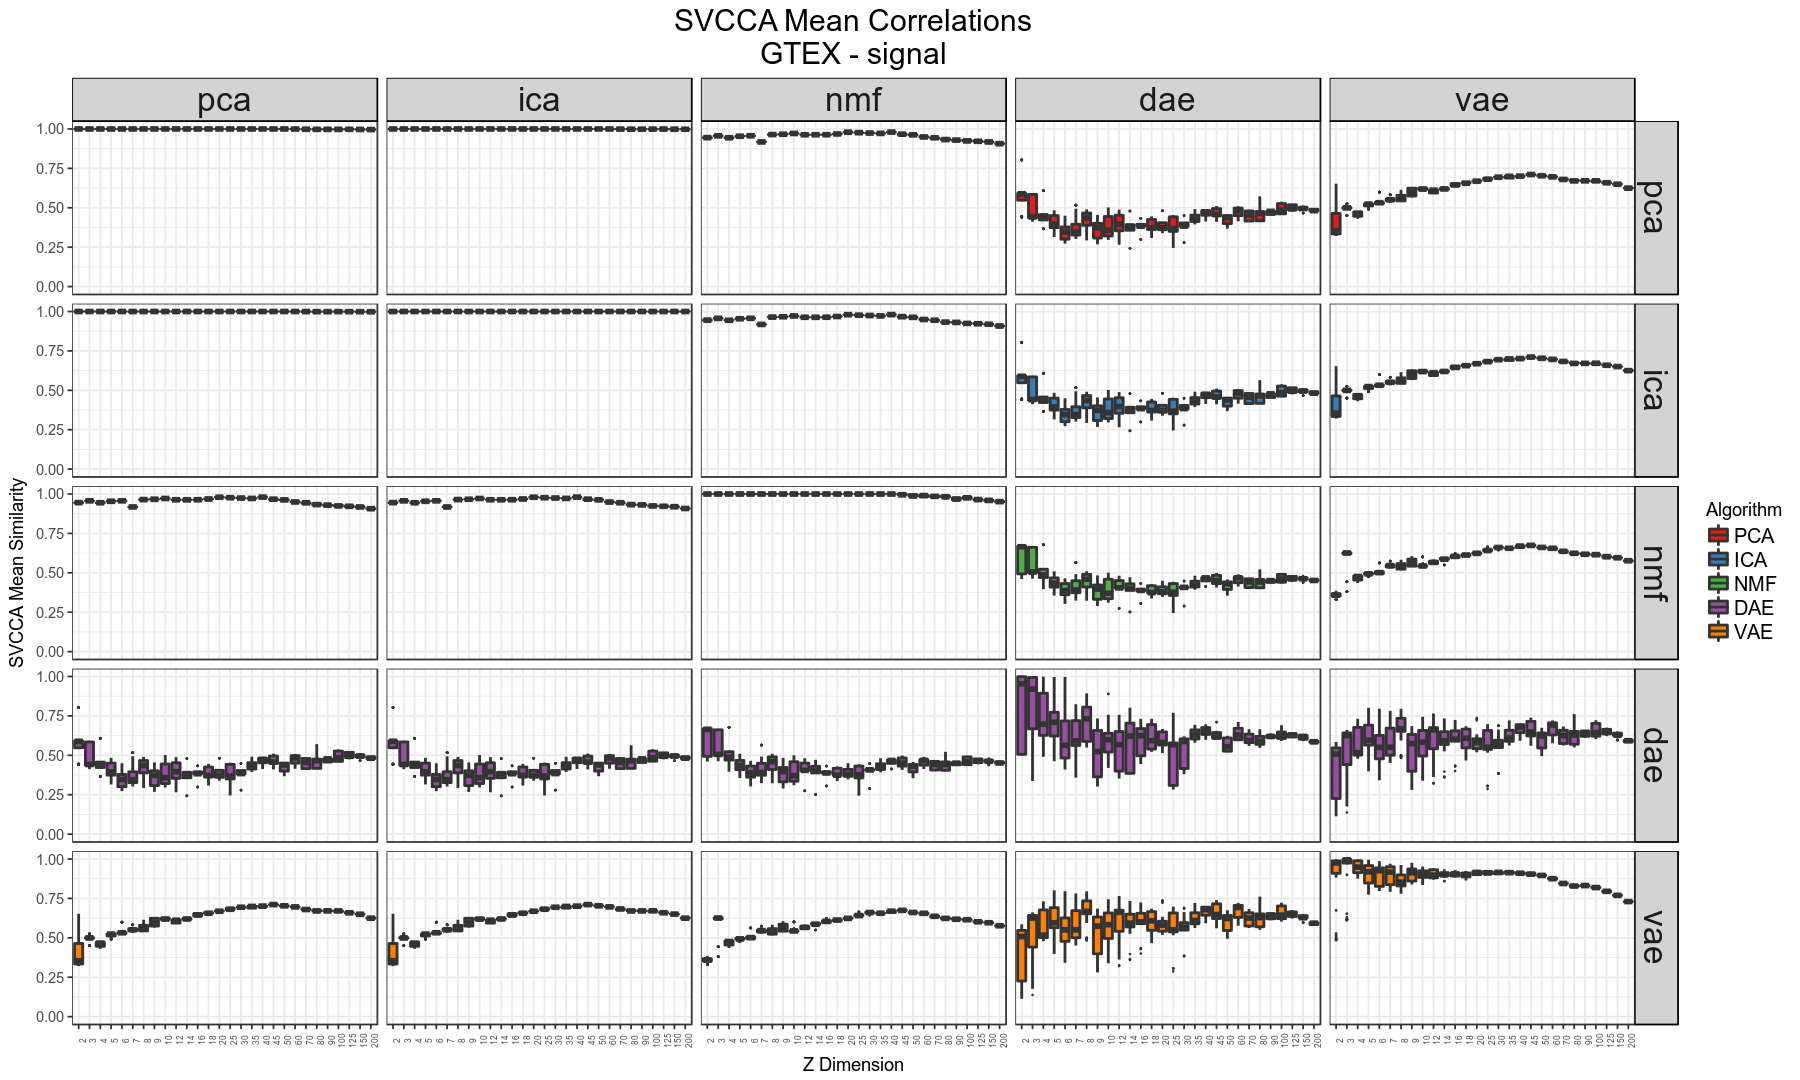

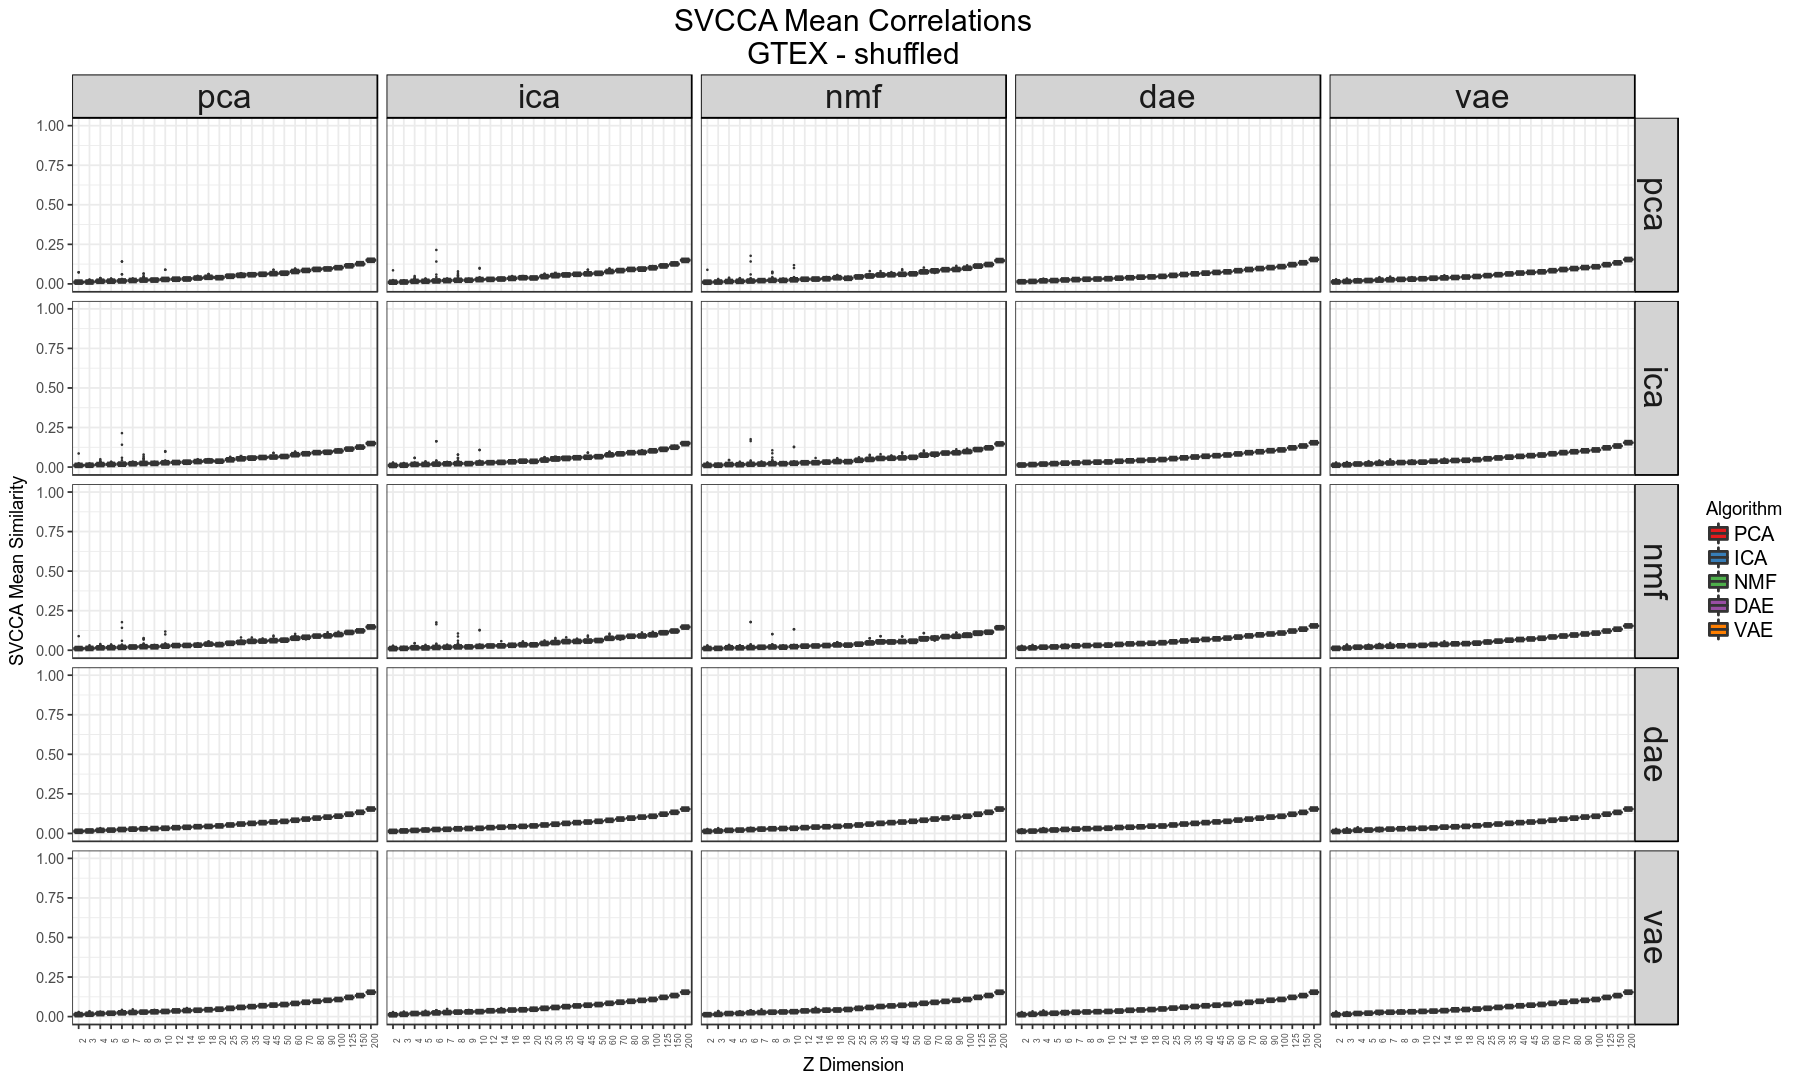

In [5]:
options(repr.plot.width = 15, repr.plot.height = 9)

for(dataset in c("TARGET", "TCGA", "GTEX")) {
    
    for(signal_contains in c("signal", "shuffled")) {

        svcca_subset_df <- svcca_df %>%
        dplyr::filter(shuffled == !!signal_contains,
                      dataset == !!dataset)

        out_figure <- paste("stability_within_z", dataset, signal_contains, sep = '_')
        out_figure <- file.path("figures", "svcca", out_figure)
        plot_title <- paste0("SVCCA Mean Correlations\n", dataset, ' - ', signal_contains)

        g <- ggplot(svcca_subset_df,
                    aes(x = z_dim, y = svcca_mean_similarity,
                        fill = algorithm_1)) +
                geom_boxplot(outlier.size = 0.1, lwd = 0.8) +
                facet_grid(algorithm_1 ~ algorithm_2) +
                xlab("Z Dimension") +
                ylab("SVCCA Mean Similarity") +
                scale_fill_manual(name = "Algorithm",
                                  values = c("#e41a1c",
                                             "#377eb8",
                                             "#4daf4a",
                                             "#984ea3",
                                             "#ff7f00"),
                                  labels = c("pca" = "PCA",
                                             "ica" = "ICA",
                                             "nmf" = "NMF",
                                             "dae" = "DAE",
                                             "vae" = "VAE")) +
                ylim(c(0, 1)) +
                ggtitle(plot_title) +
                theme_bw() +
                theme(axis.text.x = element_text(angle = 90, size = 5),
                      plot.title = element_text(hjust = 0.5, size = 18),
                      legend.text = element_text(size = 12),
                      legend.key.size = unit(1, "lines"),
                      strip.text.x = element_text(size = 20),
                      strip.text.y = element_text(size = 20),
                      strip.background = element_rect(colour = "black", fill = "lightgrey"))

        ggsave(plot = g, filename = paste0(out_figure, ".png"), height = 8, width = 12)
        ggsave(plot = g, filename = paste0(out_figure, ".pdf"), height = 8, width = 12)

        print(g)
    }
}

### Visualize subtractraction of mean signal from mean shuffled

In [6]:
svcca_subset_df <- svcca_df %>%
    dplyr::group_by(algorithm_1, algorithm_2, dataset, z_dim, shuffled) %>%
    dplyr::summarize_at('svcca_mean_similarity', mean)

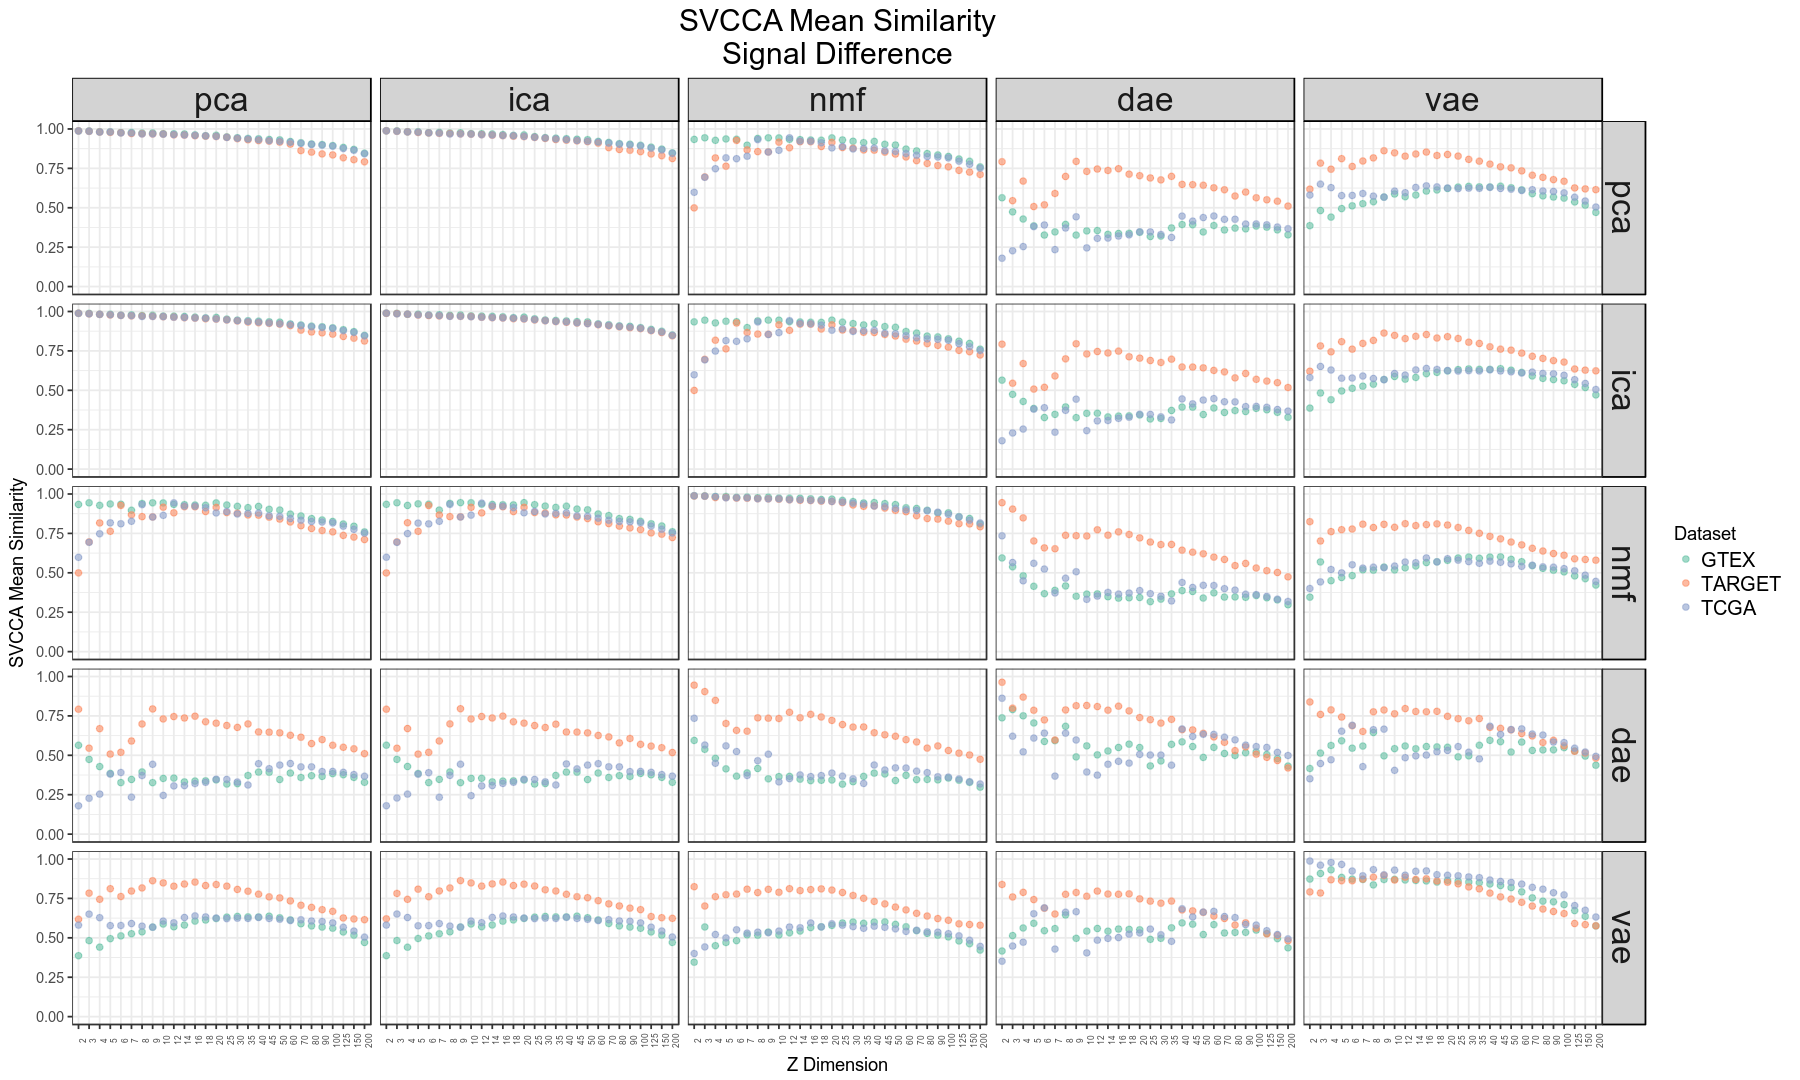

In [7]:
signal_data = svcca_subset_df %>%
    dplyr::filter(shuffled == 'signal')
shuffled_data = svcca_subset_df %>%
    dplyr::filter(shuffled == 'shuffled')

full_svcca_data = signal_data %>%
    dplyr::full_join(shuffled_data,
                     by = c('algorithm_1', 'algorithm_2', 'dataset', 'z_dim'),
                     suffix = c('_signal', '_shuffled'))

full_svcca_data <- full_svcca_data %>%
    dplyr::mutate(
        svcca_diff = svcca_mean_similarity_signal - svcca_mean_similarity_shuffled
    )

g <- ggplot(full_svcca_data, aes(x = z_dim, y = svcca_diff, color = dataset)) +
    geom_point(alpha = 0.6) +
    facet_grid(algorithm_1 ~ algorithm_2) +
    xlab("Z Dimension") +
    ylab("SVCCA Mean Similarity") +
    scale_color_manual(name = "Dataset",
                      values = c("#66c2a5",
                                 "#fc8d62",
                                 "#8da0cb"),
                      labels = c("GTEX" = "GTEX",
                                 "TCGA" = "TCGA",
                                 "TARGET" = "TARGET")) +
    ylim(c(0, 1)) +
    ggtitle(paste0('SVCCA Mean Similarity\nSignal Difference')) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, size = 5),
          plot.title = element_text(hjust = 0.5, size = 18),
          legend.text = element_text(size = 12),
          legend.key.size = unit(1, "lines"),
          strip.text.x = element_text(size = 20),
          strip.text.y = element_text(size = 20),
          strip.background = element_rect(colour = "black", fill = "lightgrey"))

out_figure = file.path("figures", "svcca", "within_z_signal_difference")

ggsave(plot = g,filename = paste0(out_figure, ".png"), height = 8, width = 11)
ggsave(plot = g, filename = paste0(out_figure, ".pdf"), height = 8, width = 11)

print(g)

## Visualize stability `across z` with SVCCA

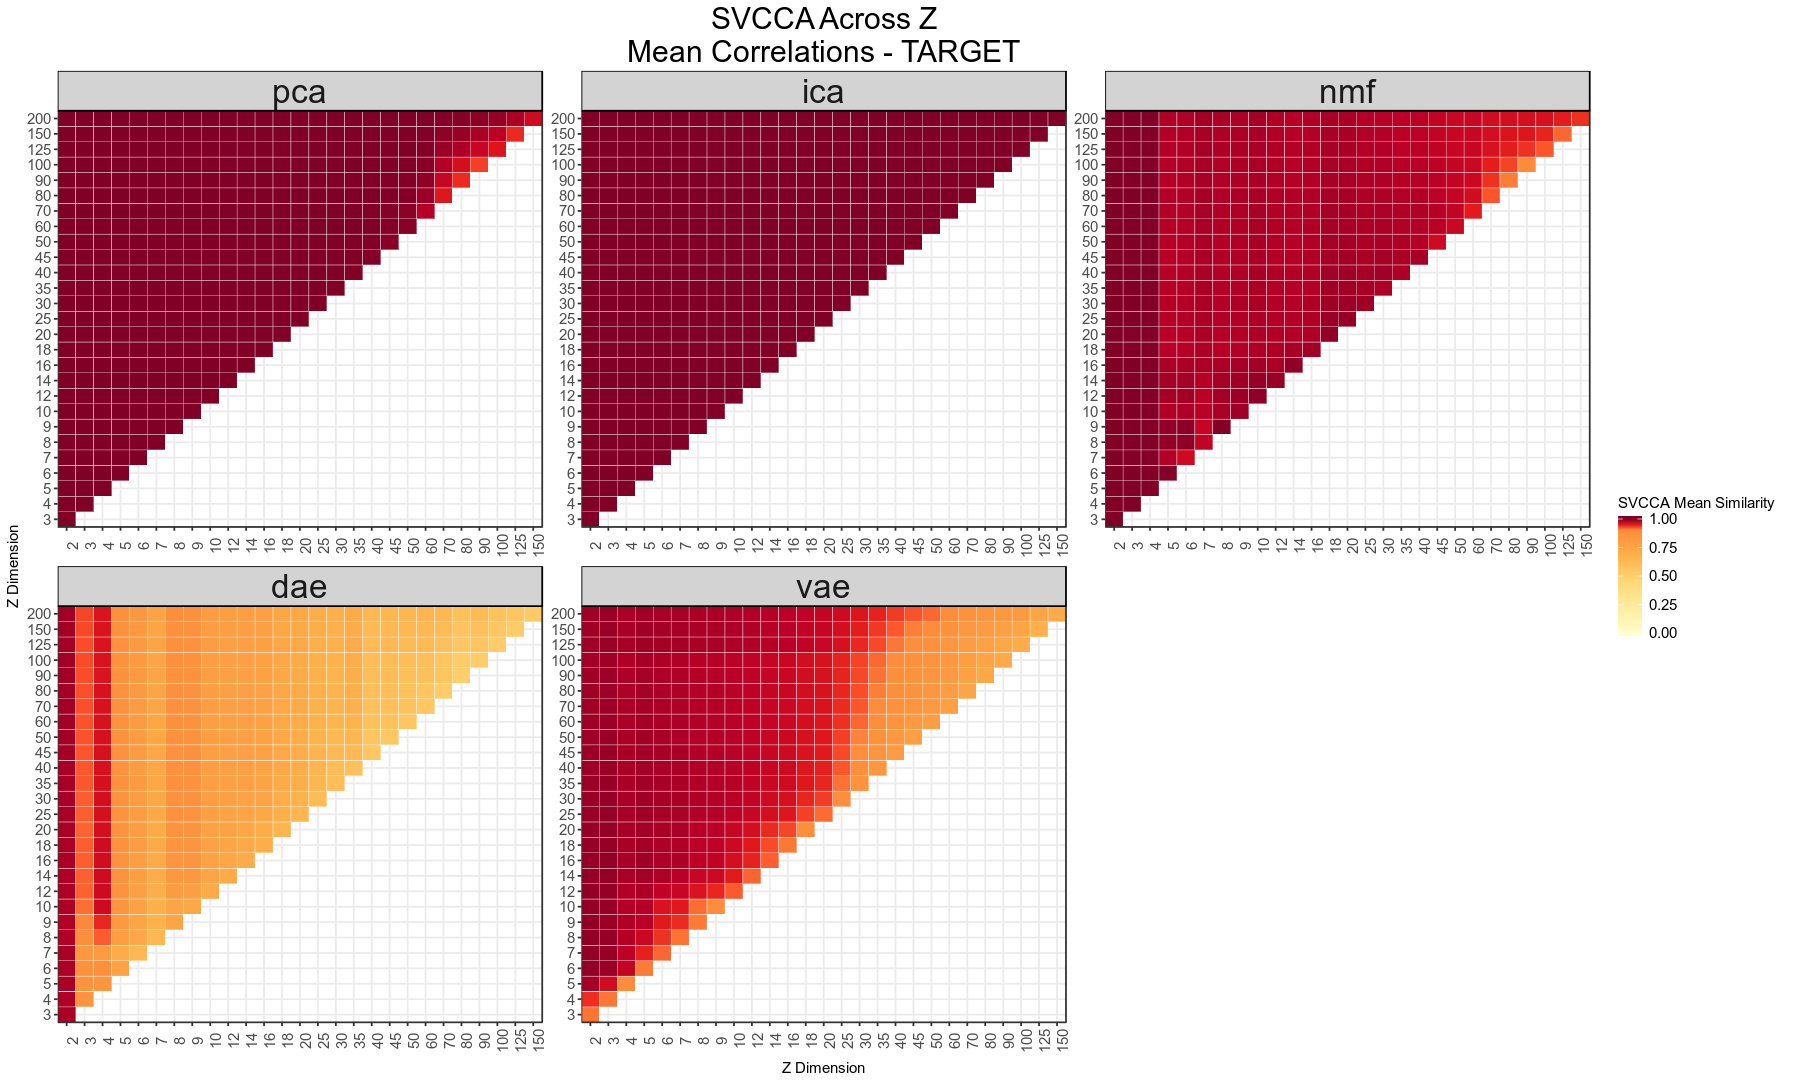

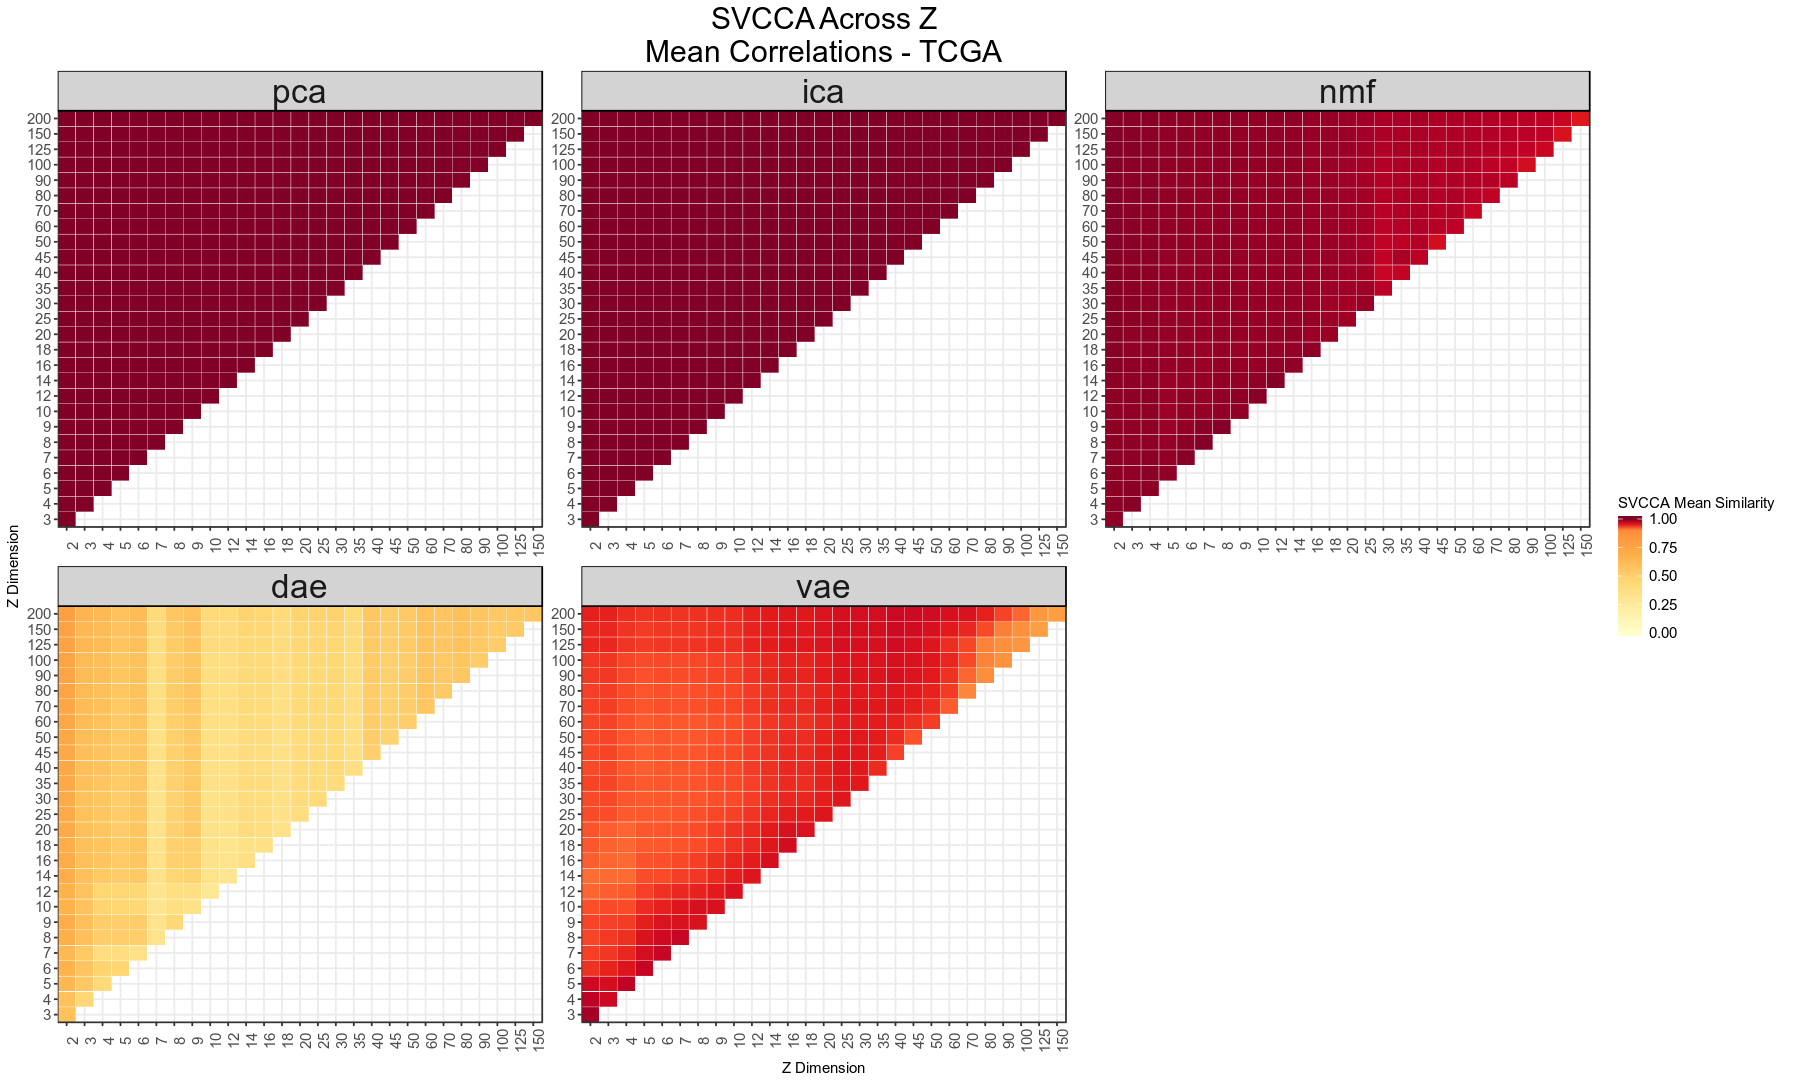

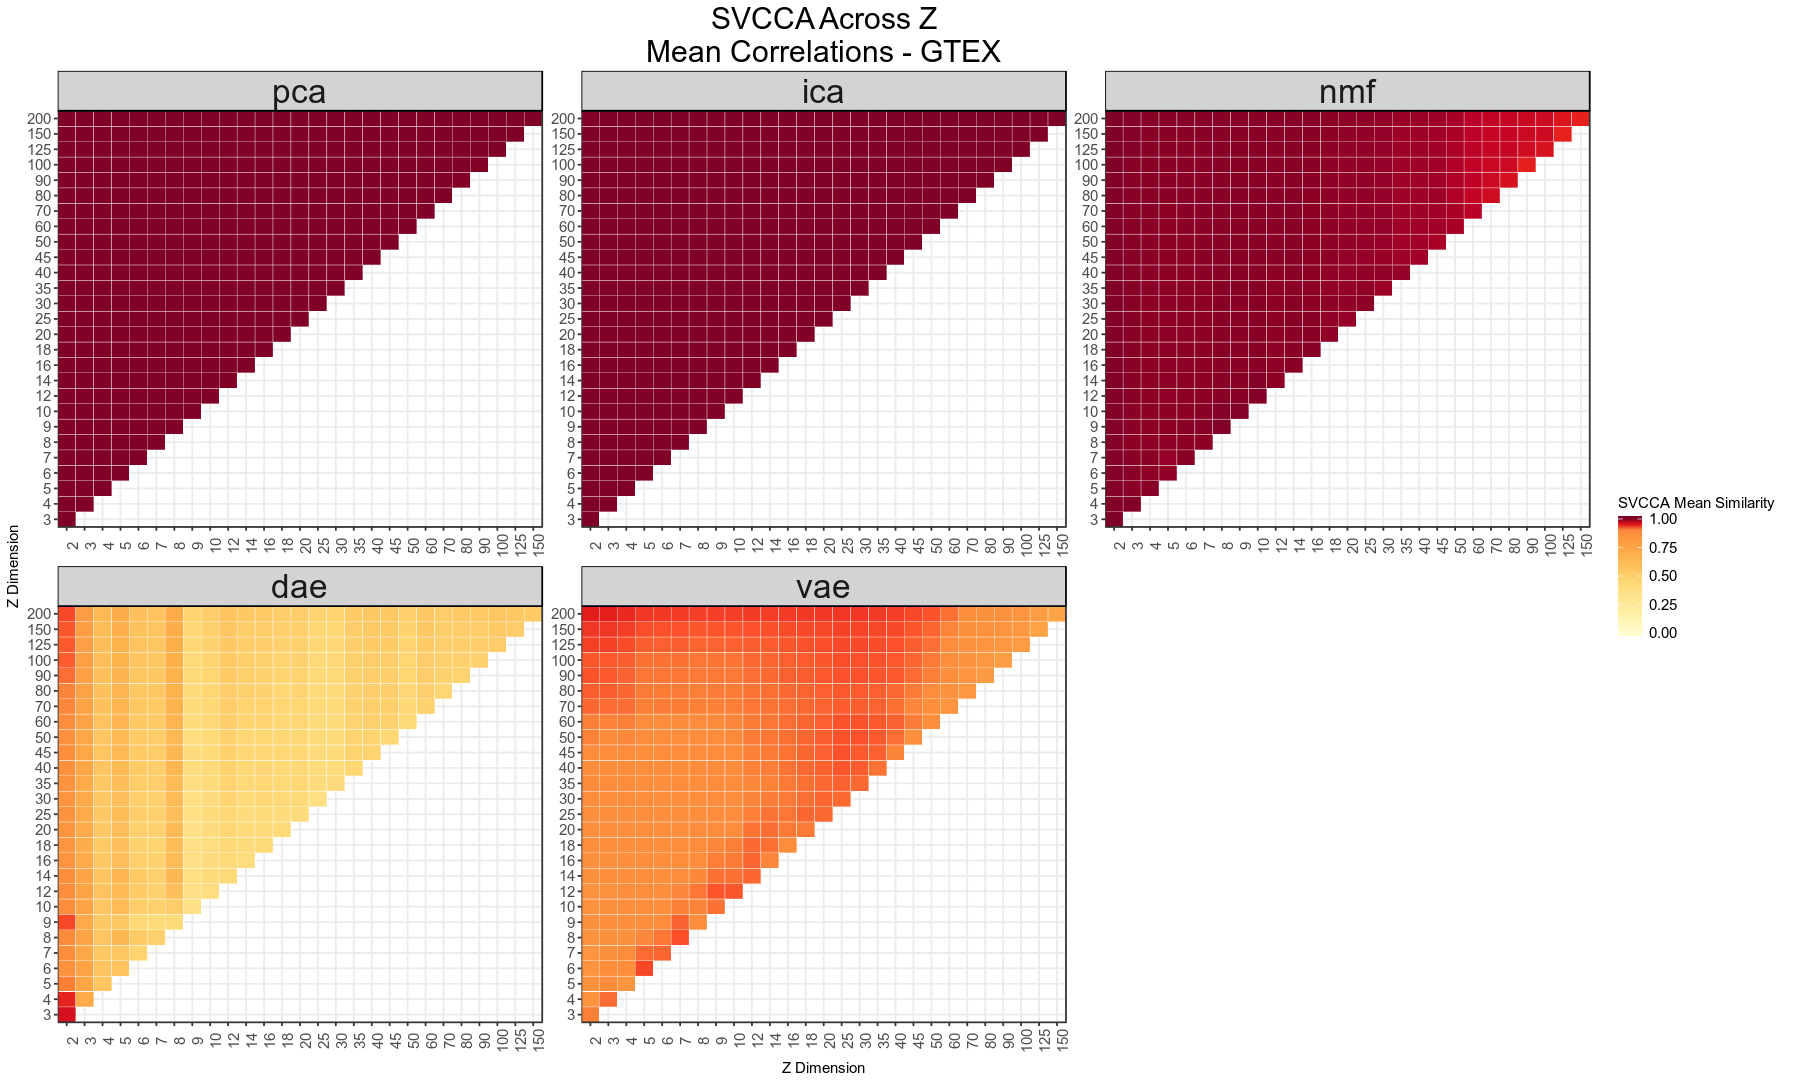

In [8]:
myPalette <- colorRampPalette(rev(brewer.pal(9, "YlOrRd")))

for (dataset in c("TARGET", "TCGA", "GTEX")) {

    # Setup filename
    data_file <- paste0("svcca_across_z_", dataset, "_mean_correlation.tsv.gz")
    data_file <- file.path('results', data_file)
    
    # Load file
    svcca_df <- readr::read_tsv(data_file,
                                col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double(),
                                z_dim_a = readr::col_integer(),
                                z_dim_b = readr::col_integer()))

    # Setup title and output file name
    plot_title <- paste0("SVCCA Across Z\nMean Correlations - ", dataset)
    out_figure <- paste0("stability_across_z_", dataset)
    out_figure <- file.path("figures", "svcca", out_figure)

    # Make sure factors are in order
    svcca_df$z_dim_a <-
        factor(svcca_df$z_dim_a,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_a))))
               )

    svcca_df$z_dim_b <-
        factor(svcca_df$z_dim_b,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_b))))
               )

    svcca_df$algorithm <- factor(svcca_df$algorithm, levels = algorithms)
    svcca_df$svcca_mean_similarity <- as.numeric(paste(svcca_df$svcca_mean_similarity))
    
    # Aggregate over each seed
    svcca_df <- svcca_df %>%
        dplyr::group_by(dataset, algorithm, z_dim_a, z_dim_b) %>%
        dplyr::summarize(svcca_mean = mean(svcca_mean_similarity))

    # Plot and save results
    g <- ggplot(svcca_df, aes(z_dim_a, z_dim_b)) +
            geom_tile(aes(fill = svcca_mean), colour = "white") +
            coord_equal() +
            scale_fill_gradientn(name = "SVCCA Mean Similarity",
                                 colours = myPalette(100),
                                 values = scales::rescale(c(1, 0.99, 0.9)),
                                 limits = c(0, 1)) +
            facet_wrap(~ algorithm, scales = "free") +
            ggtitle(plot_title) +
            theme_bw(base_size = 9) +
            theme(axis.text.x = element_text(angle = 90, size = 9),
                  axis.text.y = element_text(size = 9),
                  plot.title = element_text(hjust = 0.5, size = 18),
                  legend.text = element_text(size = 9),
                  legend.key.size = unit(1, "lines"),
                  strip.text.x = element_text(size = 20),
                  strip.text.y = element_text(size = 20),
                  strip.background = element_rect(colour = "black", fill = "lightgrey")) +
            xlab("Z Dimension") +
            ylab("Z Dimension") +
            scale_x_discrete(expand = c(0, 0)) +
            scale_y_discrete(expand = c(0, 0))

    ggsave(plot = g, filename = paste0(out_figure, ".png"), height = 8, width = 13)
    ggsave(plot = g, filename = paste0(out_figure, ".pdf"), height = 8, width = 13)

    print(g)
}